# Imports

In [41]:
# Import necessary libraries
import imageio
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy.ndimage import binary_opening, binary_closing, gaussian_filter, median_filter, morphological_gradient, binary_dilation, label
from scipy import ndimage
import cv2

# Path to the images
image_folder = "../Data/Week2/qsd2_w2/"  # Update this path as necessary
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]
mask_files = [f for f in os.listdir(image_folder) if f.endswith('.png')]
image_files.sort()
mask_files.sort()

In [42]:
def rgb2gray(image):
    """Convert an RGB image to grayscale."""
    # Normalize RGB values to [0, 1]
    image = image / 255.0

    # Apply the standard RGB-to-grayscale formula:
    # Luminance = 0.2989 * R + 0.5870 * G + 0.1140 * B
    gray_image = 0.2989 * image[..., 0] + 0.5870 * image[..., 1] + 0.1140 * image[..., 2]

    # Ensure values are in [0, 255] range
    gray_image = np.clip(gray_image * 255, 0, 255).astype(np.uint8)
    
    return gray_image

# Func Principal

In [43]:
def remove_background_morphological_gradient(image_path, filter=None, save_debug=True, thr=20, pixel_border=15):
    # Read the image
    im = imageio.imread(image_path)

    # 0. Preprocess with a Gaussian filter to reduce noise (optional)
    if filter=='gaussian':
        im = gaussian_filter(im, sigma=1)
    elif filter=='median':
        im = median_filter(im, size=3)
    # else no filtering
    
    # 1. Convert from RGB to grayscale
    im_gray = rgb2gray(im)  # Converts to 0-255 range grayscale image

    # 2. Compute morphological gradient to see gradient changes
    grad = morphological_gradient(im_gray, structure=np.ones((5, 5)))

    # 3. Thresholding to highlight the edges
    n = 0.15 # hyperparameter
    threshold = np.max(grad) * n 
    grad_bin = grad > threshold

    # 4. Opening to erase small objects
    mask = binary_opening(grad_bin, structure=np.ones((5, 5)))

    # Ensure we display debug mask when requested
    if save_debug:
        plt.imshow(mask, cmap="gray")
        plt.show()

    # --- New: compute efficient border-pixel mask ---
    # Convert to boolean for vectorized operations
    mask_bool = mask.astype(bool)
    h, w = mask_bool.shape

    # If requested, ignore pixels within pixel_border from image borders when computing extremes
    if pixel_border and int(pixel_border) > 0:
        pb = int(pixel_border)
        # create a mask copy for extremes computation where border pixels are suppressed
        mask_for_extremes = mask_bool.copy()

        # avoid pb larger than dimensions
        pb_h = min(pb, h//2)
        pb_w = min(pb, w//2)

        if pb_w > 0:
            mask_for_extremes[:, :pb_w] = False
            mask_for_extremes[:, w-pb_w:] = False
        if pb_h > 0:
            mask_for_extremes[:pb_h, :] = False
            mask_for_extremes[h-pb_h:, :] = False
    else:
        mask_for_extremes = mask_bool

    # Row-wise extremes (leftmost and rightmost white pixel per row) using masked version
    rows_any = mask_for_extremes.any(axis=1)
    left_all = mask_for_extremes.argmax(axis=1)                           # argmax returns 0 when no True; we'll mask those later
    right_all = w - 1 - np.argmax(mask_for_extremes[:, ::-1], axis=1)     # compute rightmost via flipped columns
    left = np.where(rows_any, left_all, -1)
    right = np.where(rows_any, right_all, -1)

    # Column-wise extremes (topmost and bottommost white pixel per column) using masked version
    cols_any = mask_for_extremes.any(axis=0)
    top_all = mask_for_extremes.argmax(axis=0)
    bottom_all = h - 1 - np.argmax(mask_for_extremes[::-1, :], axis=0)
    top = np.where(cols_any, top_all, -1)
    bottom = np.where(cols_any, bottom_all, -1)

    # ------------------ Filtrado por mediana ------------------
    # Verticales (left/right): mediana en eje horizontal (columnas)
    left_filtered = left.copy()
    right_filtered = right.copy()

    valid_left = left_filtered >= 0
    if valid_left.any():
        med_left = int(np.median(left_filtered[valid_left]))
        left_filtered[valid_left] = np.where(np.abs(left_filtered[valid_left] - med_left) <= thr, left_filtered[valid_left], -1)

    valid_right = right_filtered >= 0
    if valid_right.any():
        med_right = int(np.median(right_filtered[valid_right]))
        right_filtered[valid_right] = np.where(np.abs(right_filtered[valid_right] - med_right) <= thr, right_filtered[valid_right], -1)

    # Horizontales (top/bottom): mediana en eje vertical (filas)
    top_filtered = top.copy()
    bottom_filtered = bottom.copy()

    valid_top = top_filtered >= 0
    if valid_top.any():
        med_top = int(np.median(top_filtered[valid_top]))
        top_filtered[valid_top] = np.where(np.abs(top_filtered[valid_top] - med_top) <= thr, top_filtered[valid_top], -1)

    valid_bottom = bottom_filtered >= 0
    if valid_bottom.any():
        med_bottom = int(np.median(bottom_filtered[valid_bottom]))
        bottom_filtered[valid_bottom] = np.where(np.abs(bottom_filtered[valid_bottom] - med_bottom) <= thr, bottom_filtered[valid_bottom], -1)

    # Build border mask by marking the filtered extremes along rows and columns
    border_mask = np.zeros_like(mask_bool, dtype=bool)

    # Use explicit loops to avoid indexing -1 positions
    row_inds = np.where(rows_any)[0]
    for r in row_inds:
        if left_filtered[r] >= 0:
            border_mask[r, left_filtered[r]] = True
        if right_filtered[r] >= 0:
            border_mask[r, right_filtered[r]] = True

    col_inds = np.where(cols_any)[0]
    for c in col_inds:
        if top_filtered[c] >= 0:
            border_mask[top_filtered[c], c] = True
        if bottom_filtered[c] >= 0:
            border_mask[bottom_filtered[c], c] = True

    # ------------------ Fit lines for each side and build polygon ------------------
    # Helper: fit x = a*y + b for vertical-like sides (left/right)
    def fit_x_of_y(indices, values):
        # indices: array of y coordinates, values: corresponding x coordinates
        if len(indices) >= 2:
            a, b = np.polyfit(indices, values, 1)  # x = a*y + b
        elif len(indices) == 1:
            a, b = 0.0, float(values[0])
        else:
            a, b = None, None
        return a, b

    # Helper: fit y = c*x + d for horizontal-like sides (top/bottom)
    def fit_y_of_x(indices, values):
        # indices: array of x coordinates, values: corresponding y coordinates
        if len(indices) >= 2:
            c, d = np.polyfit(indices, values, 1)  # y = c*x + d
        elif len(indices) == 1:
            c, d = 0.0, float(values[0])
        else:
            c, d = None, None
        return c, d

    # Collect points for each side
    rows_left = np.where(left_filtered >= 0)[0]
    xs_left = left_filtered[rows_left] if rows_left.size > 0 else np.array([])

    rows_right = np.where(right_filtered >= 0)[0]
    xs_right = right_filtered[rows_right] if rows_right.size > 0 else np.array([])

    cols_top = np.where(top_filtered >= 0)[0]
    ys_top = top_filtered[cols_top] if cols_top.size > 0 else np.array([])

    cols_bottom = np.where(bottom_filtered >= 0)[0]
    ys_bottom = bottom_filtered[cols_bottom] if cols_bottom.size > 0 else np.array([])

    # Fit lines
    a_left, b_left = fit_x_of_y(rows_left, xs_left)
    a_right, b_right = fit_x_of_y(rows_right, xs_right)
    c_top, d_top = fit_y_of_x(cols_top, ys_top)
    c_bottom, d_bottom = fit_y_of_x(cols_bottom, ys_bottom)

    # Intersection helper between x = a*y + b and y = c*x + d
    def intersect_vert_horiz(a, b, c, d):
        # Solve x = a*y + b and y = c*x + d -> x = a*(c*x + d) + b -> x*(1 - a*c) = a*d + b
        if a is None or c is None:
            return None
        denom = (1.0 - a * c)
        if abs(denom) < 1e-6:
            return None
        x = (a * d + b) / denom
        y = c * x + d
        return (x, y)

    # Compute four intersections: left-top, top-right, right-bottom, bottom-left
    pts = []
    it = intersect_vert_horiz(a_left, b_left, c_top, d_top)
    pts.append(it if it is not None else None)
    it = intersect_vert_horiz(a_right, b_right, c_top, d_top)
    pts.append(it if it is not None else None)
    it = intersect_vert_horiz(a_right, b_right, c_bottom, d_bottom)
    pts.append(it if it is not None else None)
    it = intersect_vert_horiz(a_left, b_left, c_bottom, d_bottom)
    pts.append(it if it is not None else None)

    # Fallback: if any intersection is None, replace with nearest available extreme (median)
    # Convert to safe integer coordinates inside image
    final_pts = []
    for i, p in enumerate(pts):
        if p is None:
            # fallback strategy depending on corner index
            if i == 0:  # left-top
                x = np.median(xs_left) if xs_left.size>0 else 0
                y = np.median(ys_top) if ys_top.size>0 else 0
            elif i == 1:  # right-top
                x = np.median(xs_right) if xs_right.size>0 else (w-1)
                y = np.median(ys_top) if ys_top.size>0 else 0
            elif i == 2:  # right-bottom
                x = np.median(xs_right) if xs_right.size>0 else (w-1)
                y = np.median(ys_bottom) if ys_bottom.size>0 else (h-1)
            else:  # left-bottom
                x = np.median(xs_left) if xs_left.size>0 else 0
                y = np.median(ys_bottom) if ys_bottom.size>0 else (h-1)
            p = (float(x), float(y))
        # Clip and round
        x_cl = int(np.clip(round(p[0]), 0, w - 1))
        y_cl = int(np.clip(round(p[1]), 0, h - 1))
        final_pts.append((x_cl, y_cl))

    # Create polygon and fill
    polygon = np.array(final_pts, dtype=np.int32)
    poly_mask = np.zeros((h, w), dtype=np.uint8)
    try:
        cv2.fillPoly(poly_mask, [polygon], 1)
    except Exception:
        # In case polygon is degenerate, fallback to previous small border mask
        poly_mask = border_mask.astype(np.uint8)

    # Prepare final mask (uint8) and apply to image
    mask_rect = poly_mask

    output_image = im * mask_rect[:, :, np.newaxis]
    # Always prepare normalized gradient for visualization and return it
    grad_norm = (255 * (grad.astype(np.float32) - grad.min()) / ( (grad.max() - grad.min()) + 1e-8 )).astype(np.uint8)

    return im, mask_rect, output_image, grad_norm

C:\Users\Adrià\AppData\Local\Temp\ipykernel_23264\1413024247.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  im = imageio.imread(image_path)
C:\Users\Adrià\AppData\Local\Temp\ipykernel_23264\1106199881.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  gt_raw = imageio.imread(gt_path)
C:\Users\Adrià\AppData\Local\Temp\ipykernel_23264\1106199881.py:24: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2

00000.jpg -> Precision: 0.8265, Recall: 0.8642, F1: 0.8449


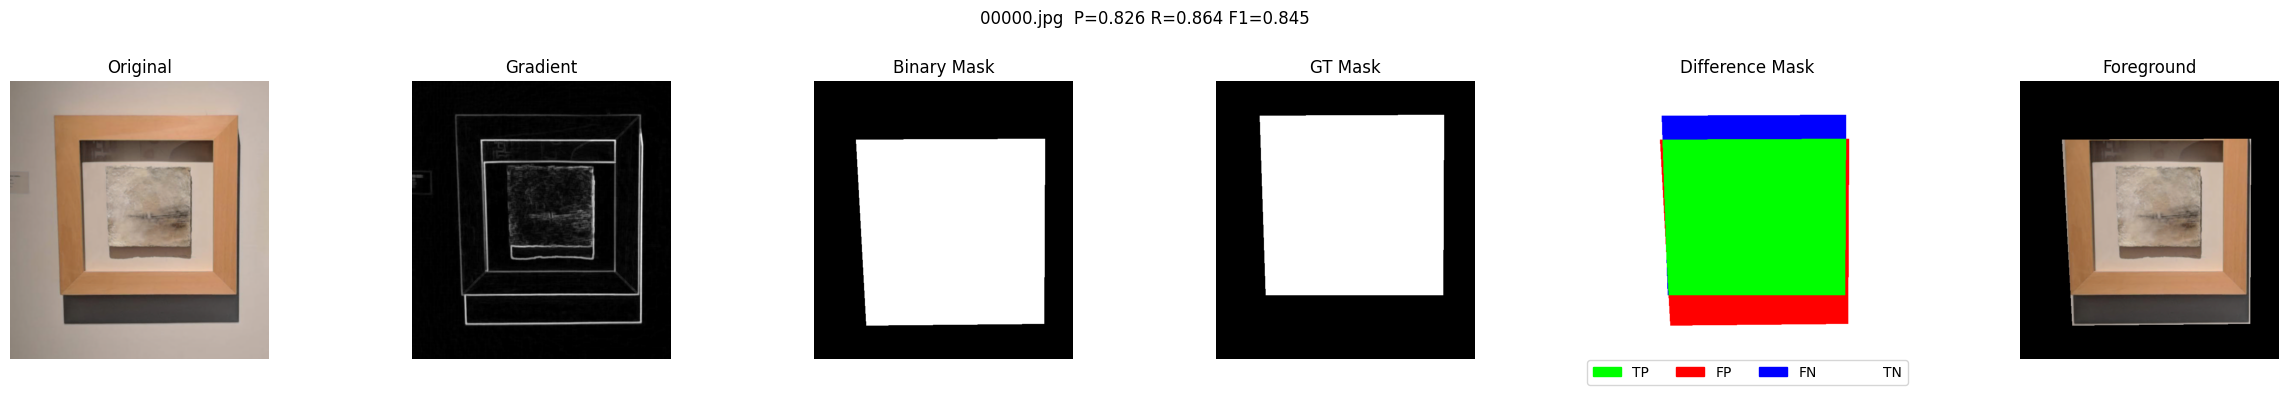

00001.jpg -> Precision: 0.9867, Recall: 1.0000, F1: 0.9933


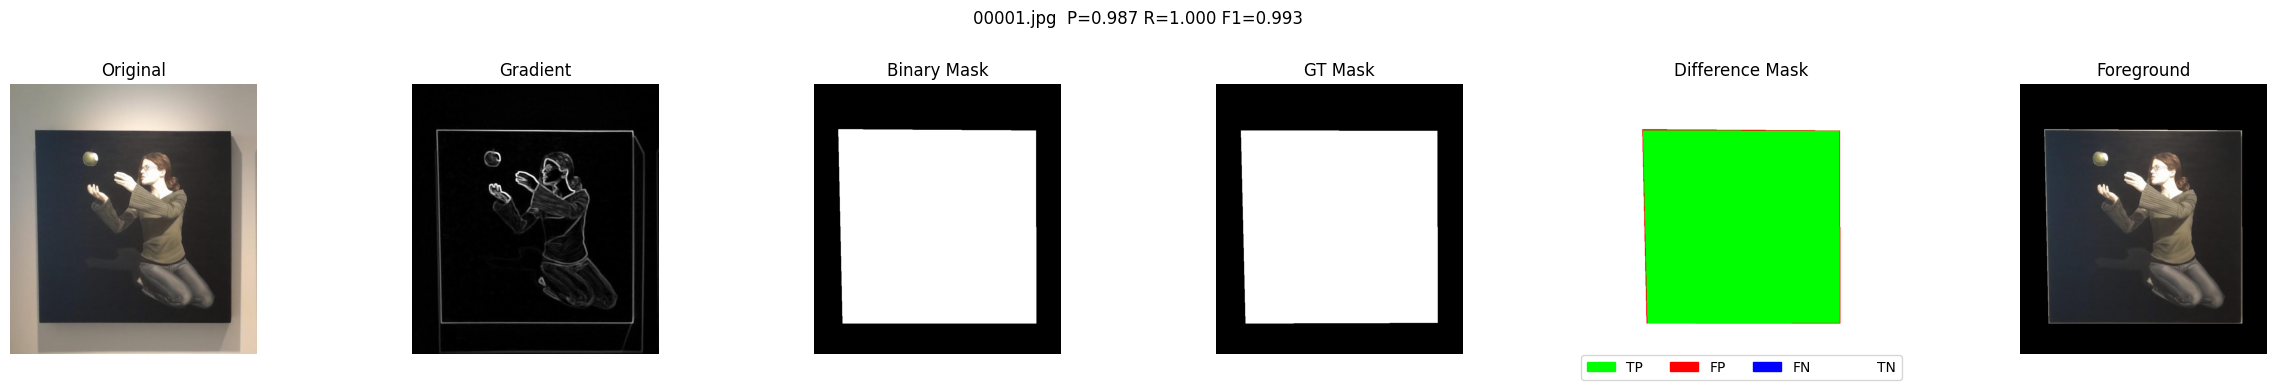

00002.jpg -> Precision: 0.9112, Recall: 1.0000, F1: 0.9535


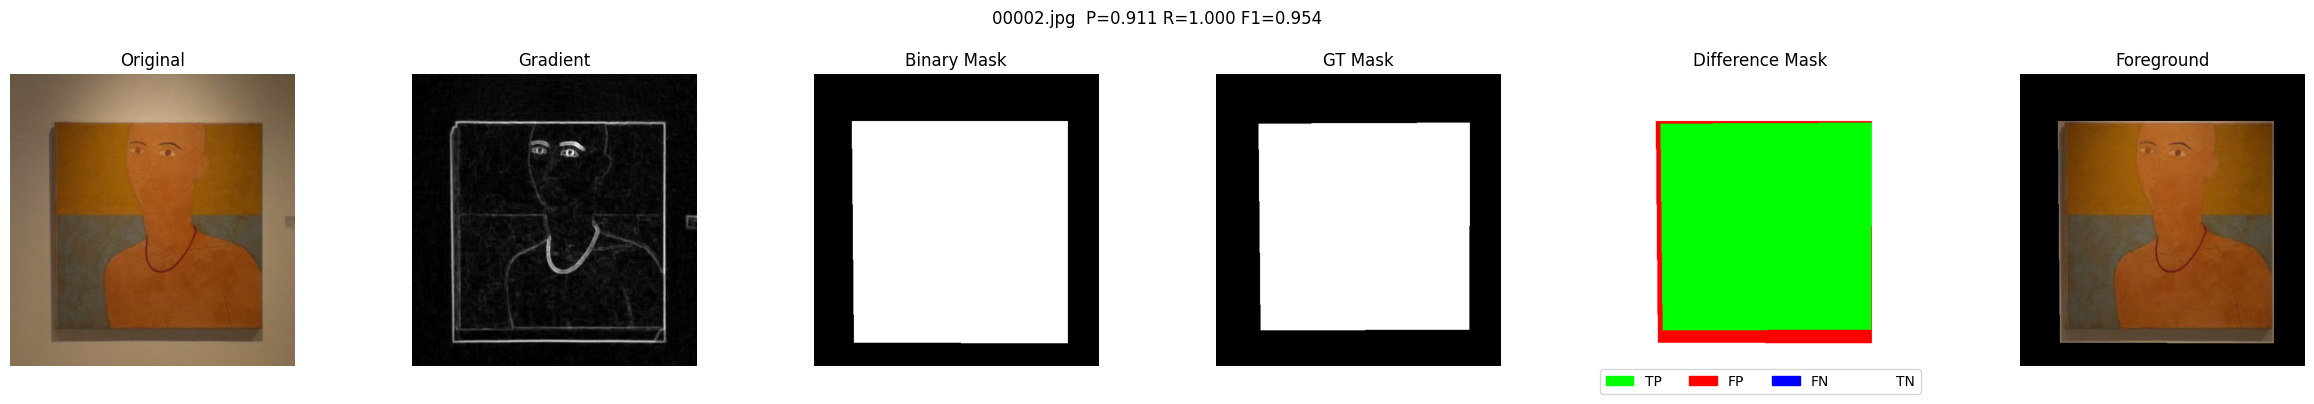

00003.jpg -> Precision: 0.9148, Recall: 1.0000, F1: 0.9555


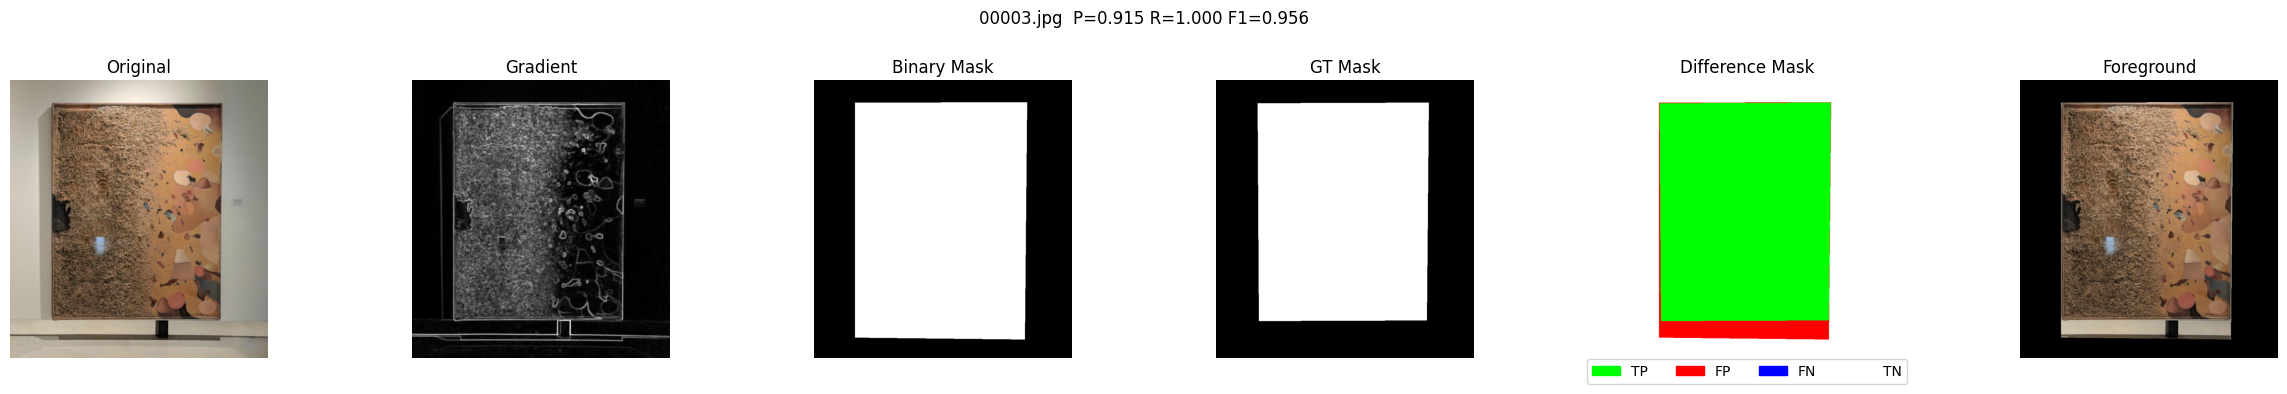

00004.jpg -> Precision: 0.8598, Recall: 1.0000, F1: 0.9246


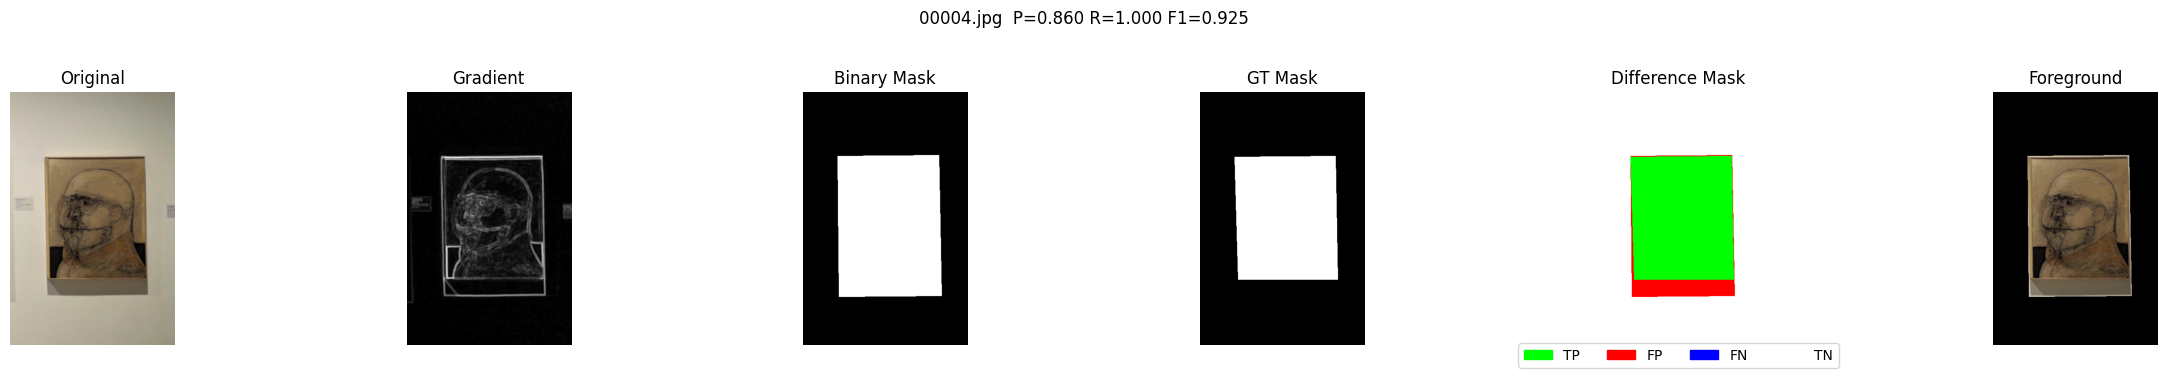

00005.jpg -> Precision: 0.9941, Recall: 0.9961, F1: 0.9951


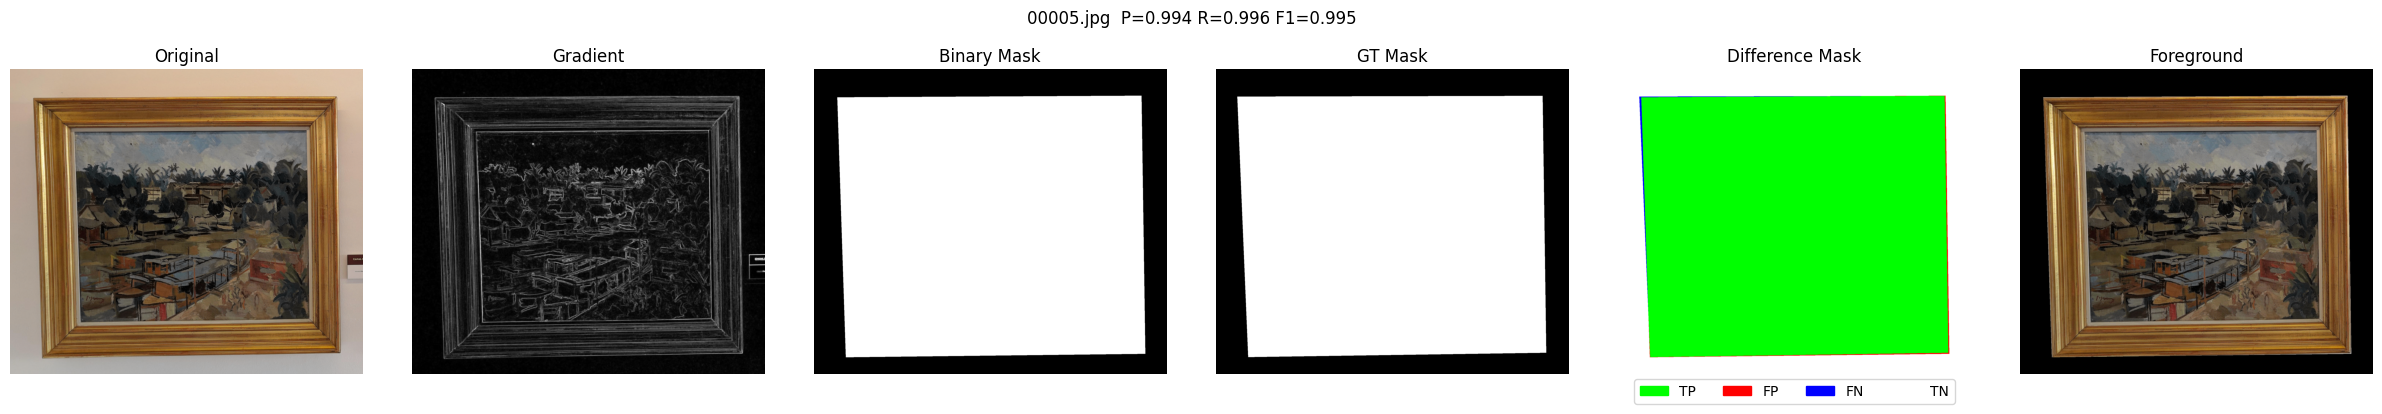

00006.jpg -> Precision: 0.9932, Recall: 0.9995, F1: 0.9963


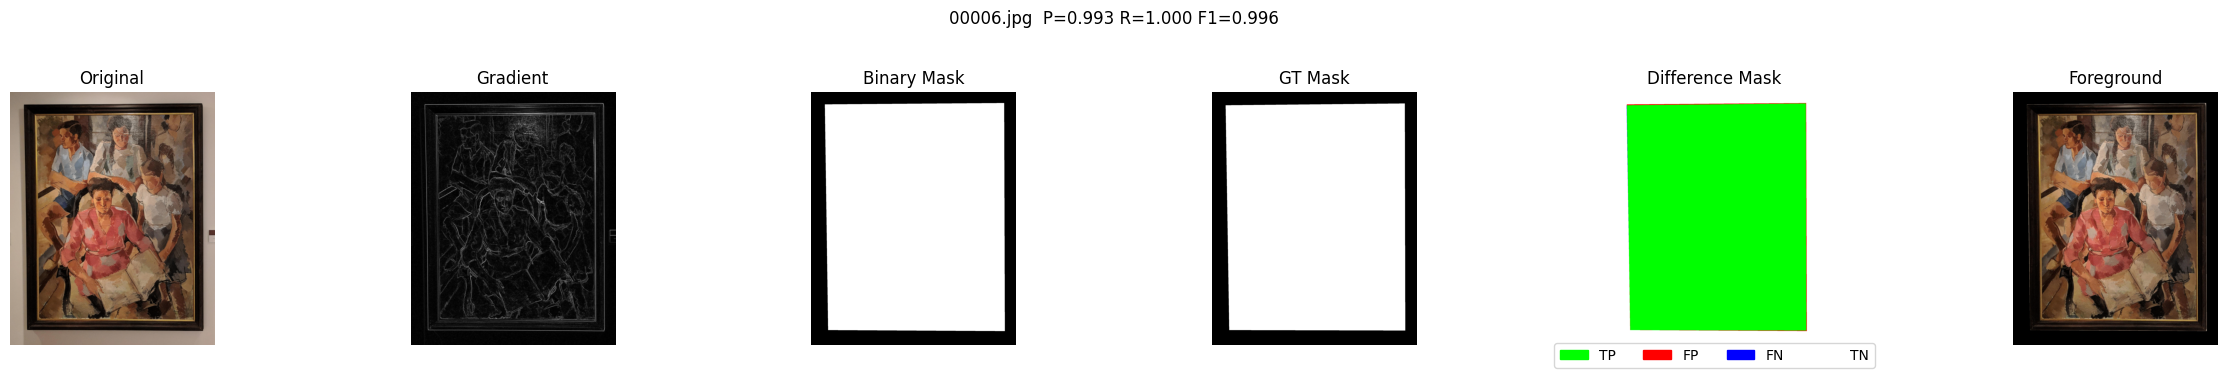

00007.jpg -> Precision: 0.8785, Recall: 1.0000, F1: 0.9353


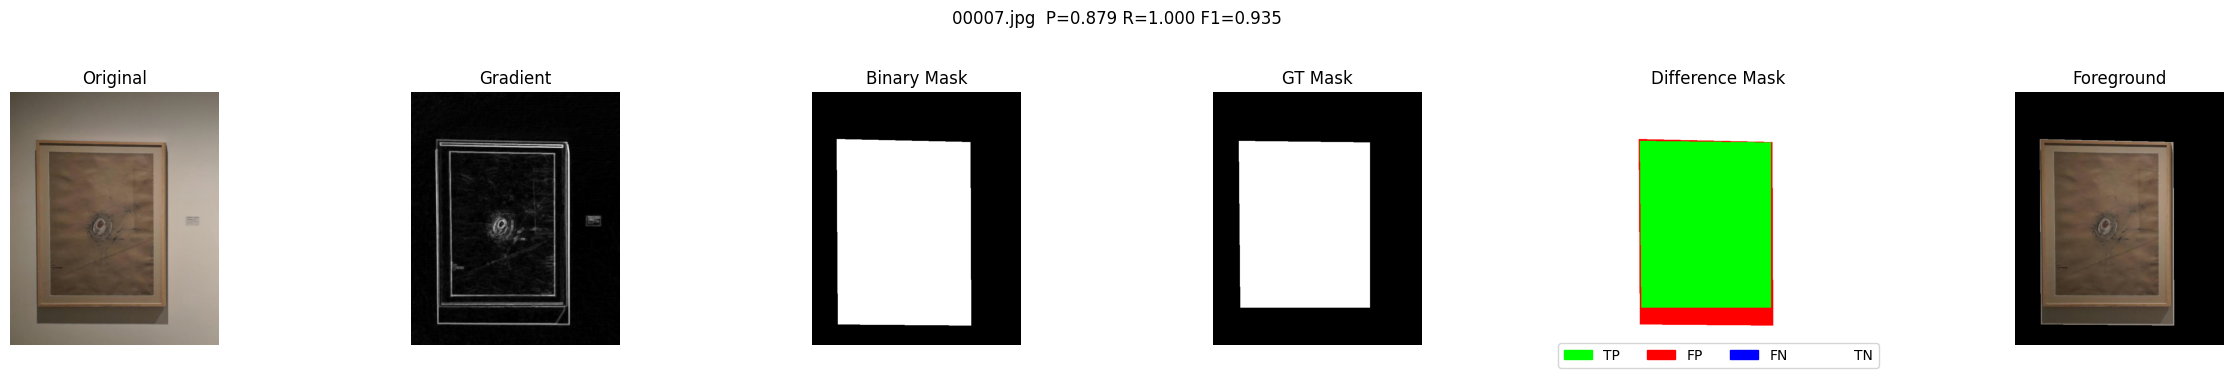

00008.jpg -> Precision: 0.9786, Recall: 1.0000, F1: 0.9892


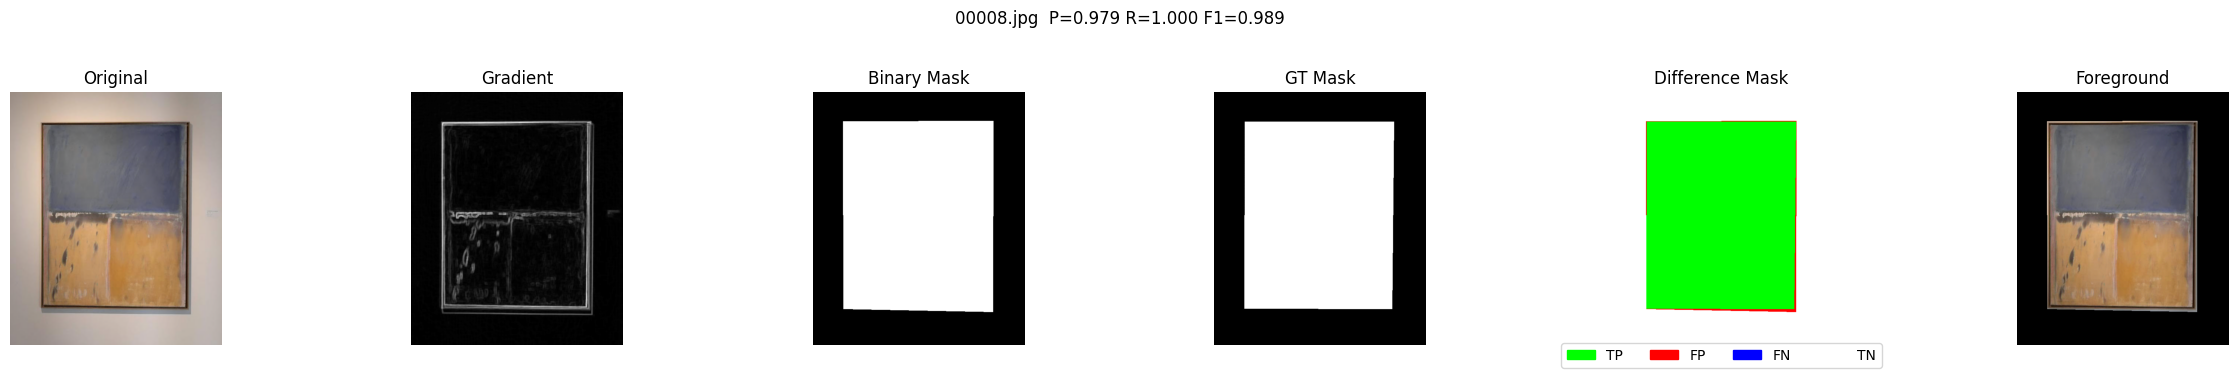

00009.jpg -> Precision: 0.8465, Recall: 0.9987, F1: 0.9163


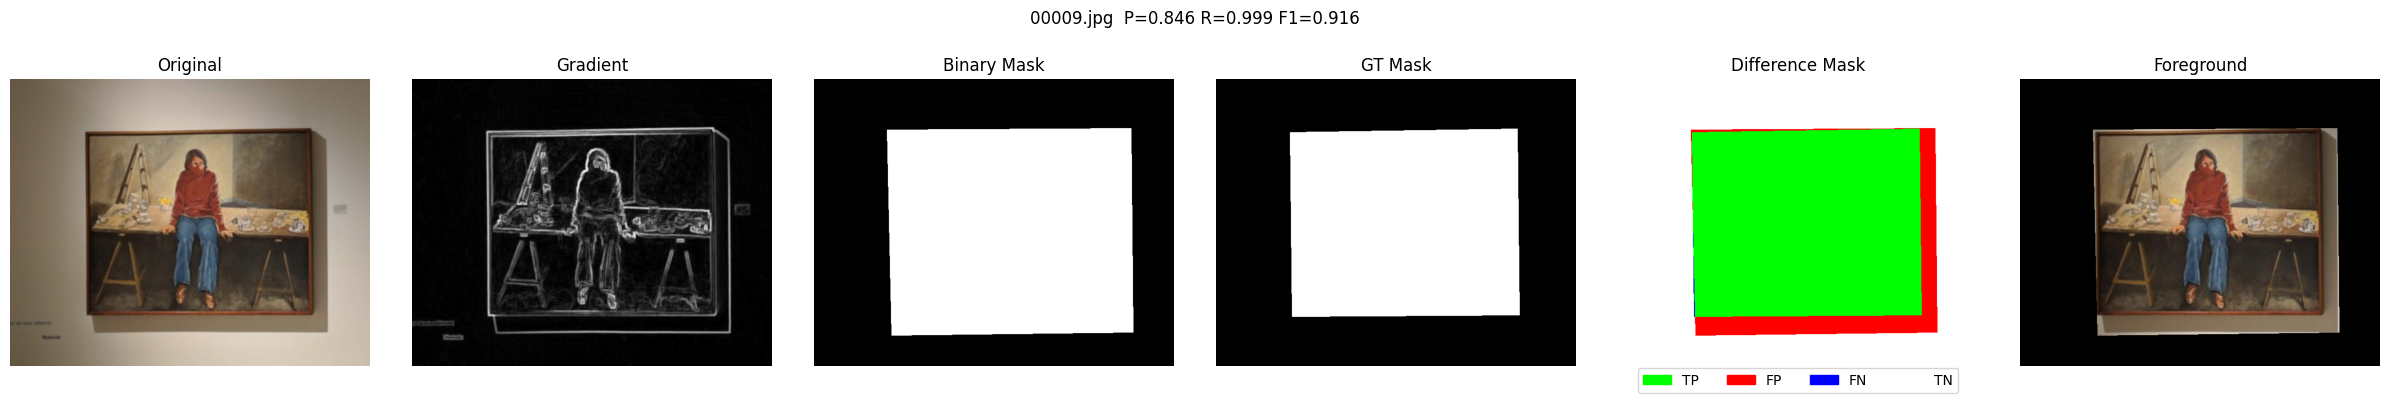

00010.jpg -> Precision: 0.9939, Recall: 0.3350, F1: 0.5011


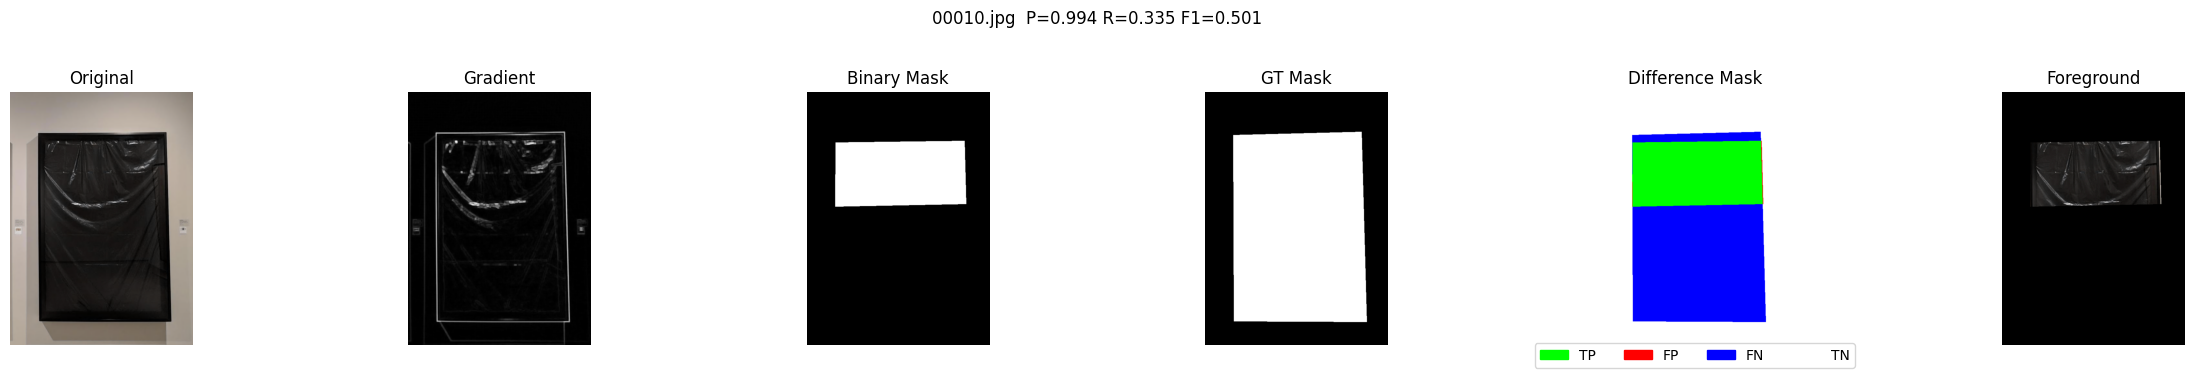

00011.jpg -> Precision: 0.9973, Recall: 0.9882, F1: 0.9927


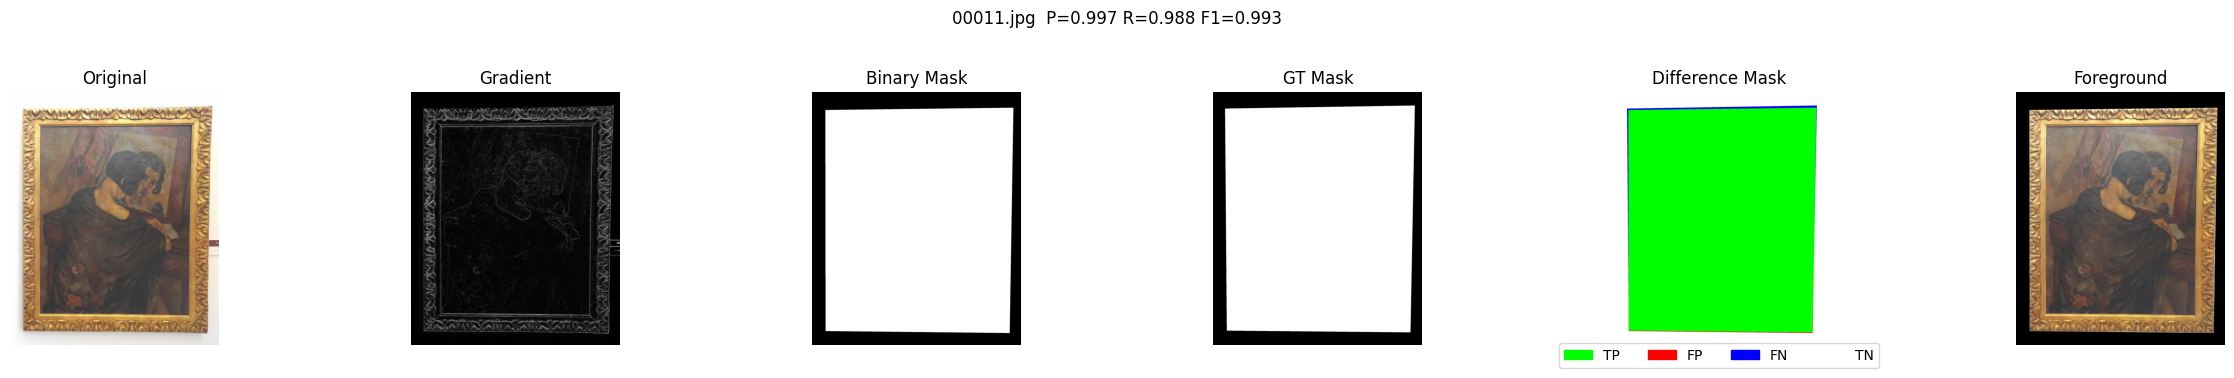

00012.jpg -> Precision: 0.9941, Recall: 0.9969, F1: 0.9955


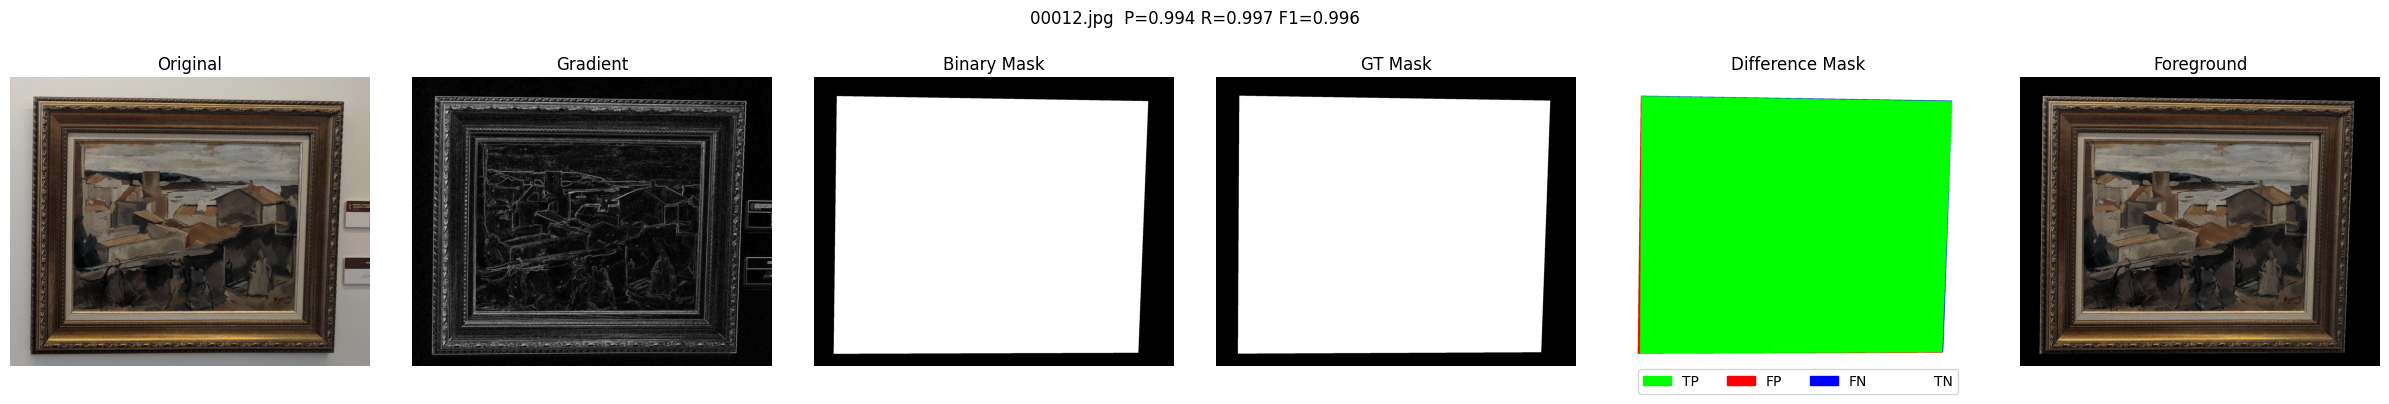

00013.jpg -> Precision: 0.9922, Recall: 0.8853, F1: 0.9357


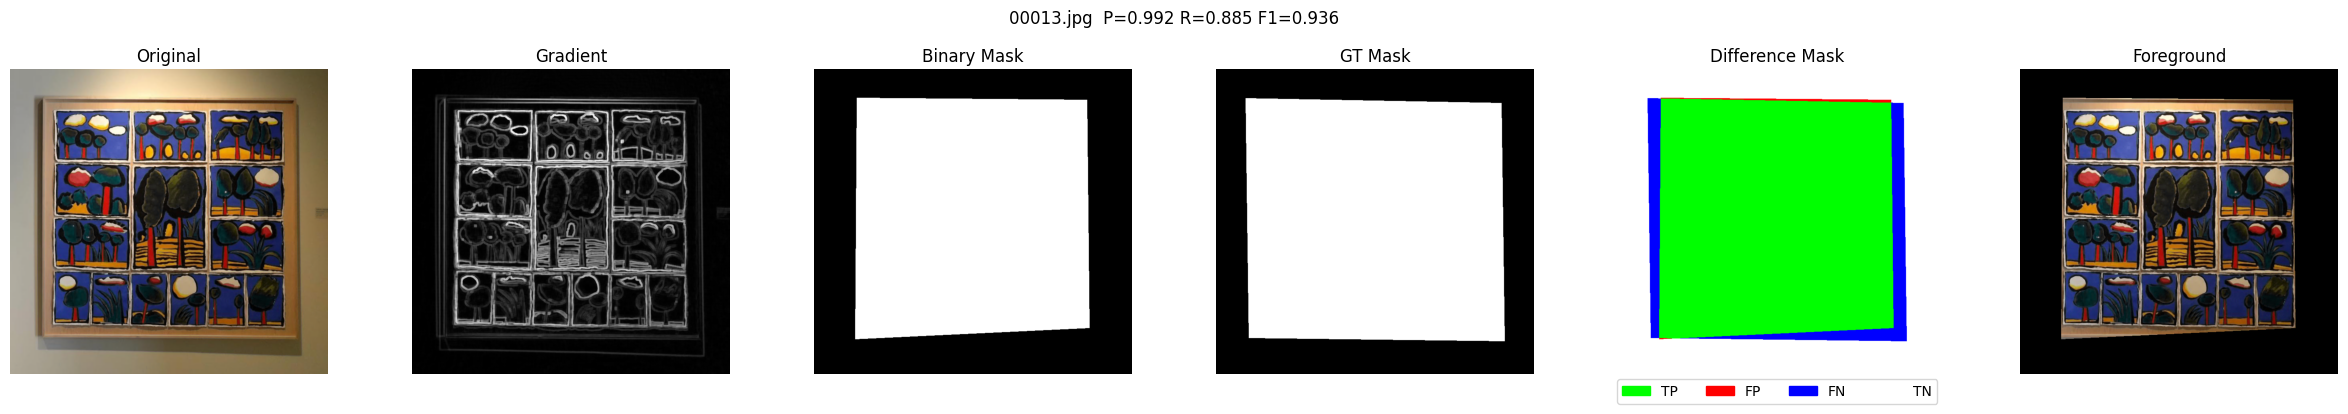

00014.jpg -> Precision: 0.8133, Recall: 0.9957, F1: 0.8953


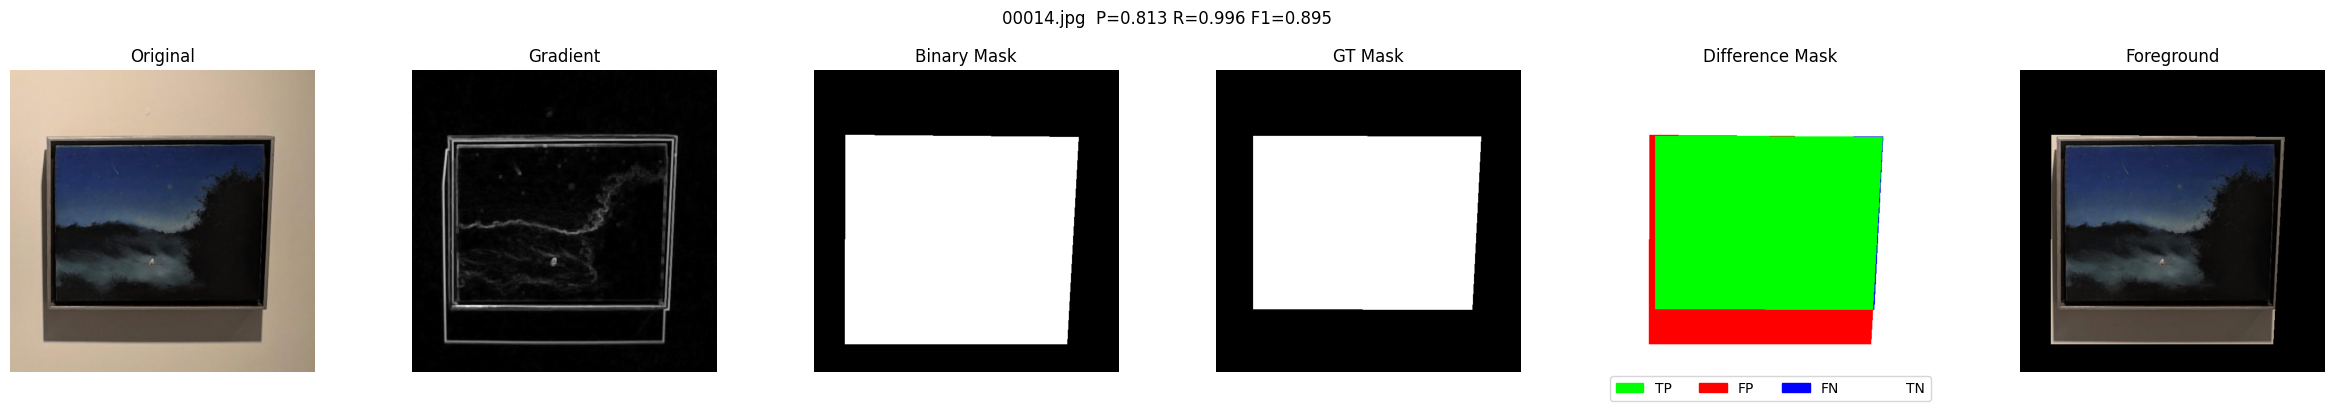

00015.jpg -> Precision: 1.0000, Recall: 0.9694, F1: 0.9845


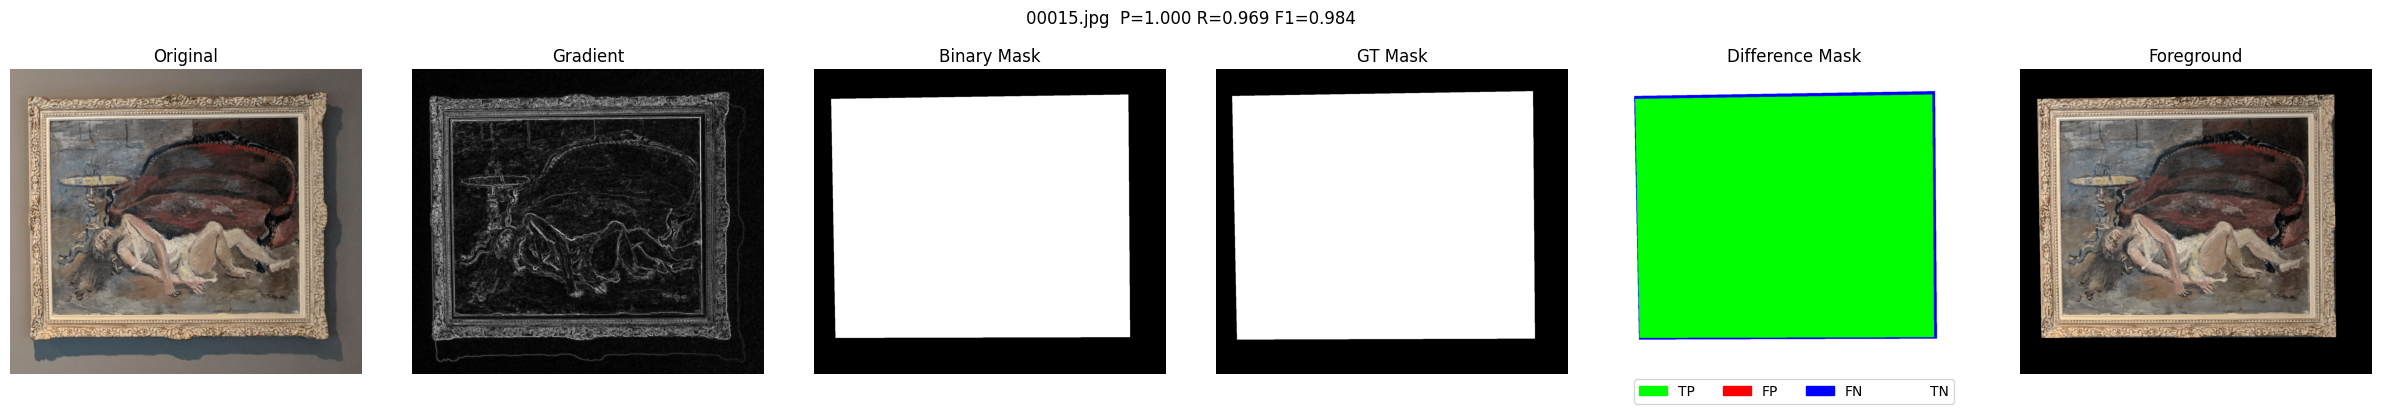

00016.jpg -> Precision: 0.9992, Recall: 0.9949, F1: 0.9971


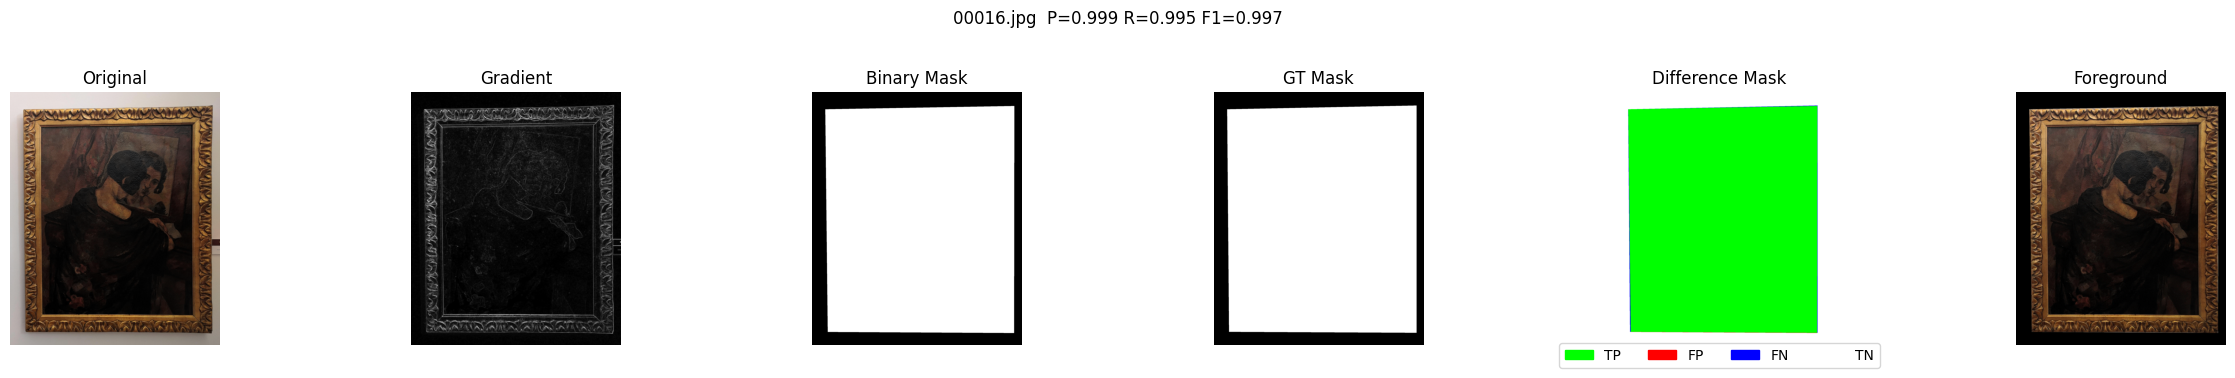

00017.jpg -> Precision: 1.0000, Recall: 0.9821, F1: 0.9910


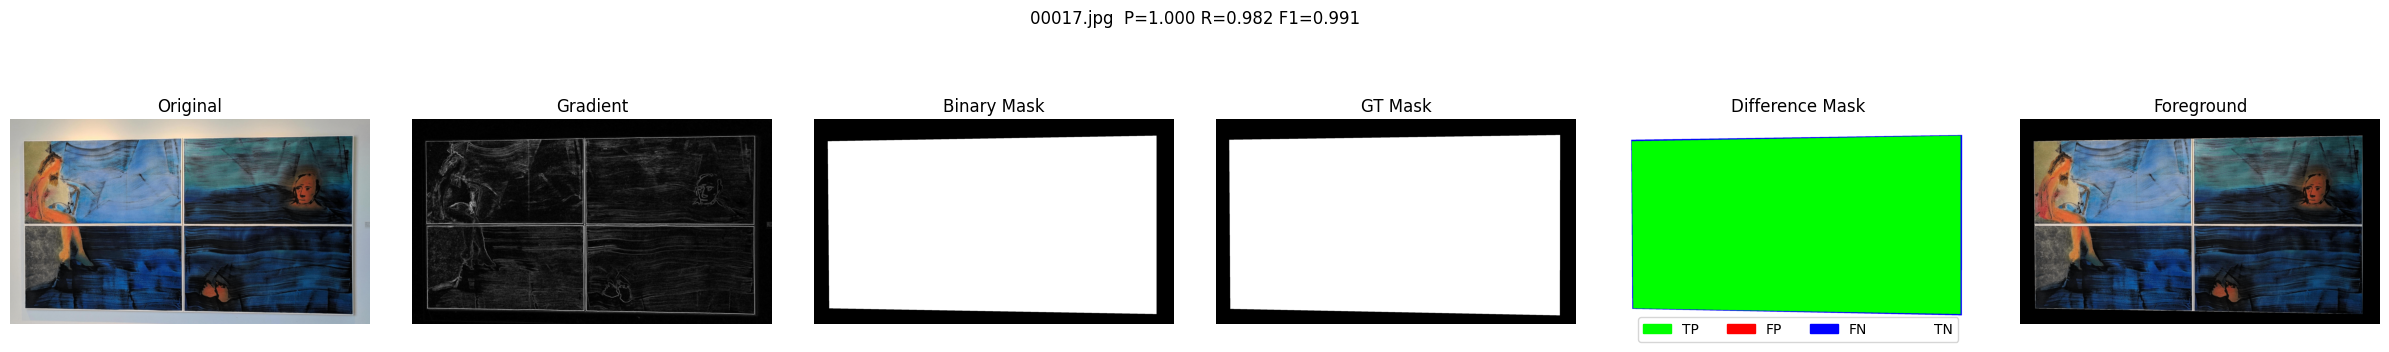

00018.jpg -> Precision: 0.9676, Recall: 0.9182, F1: 0.9422


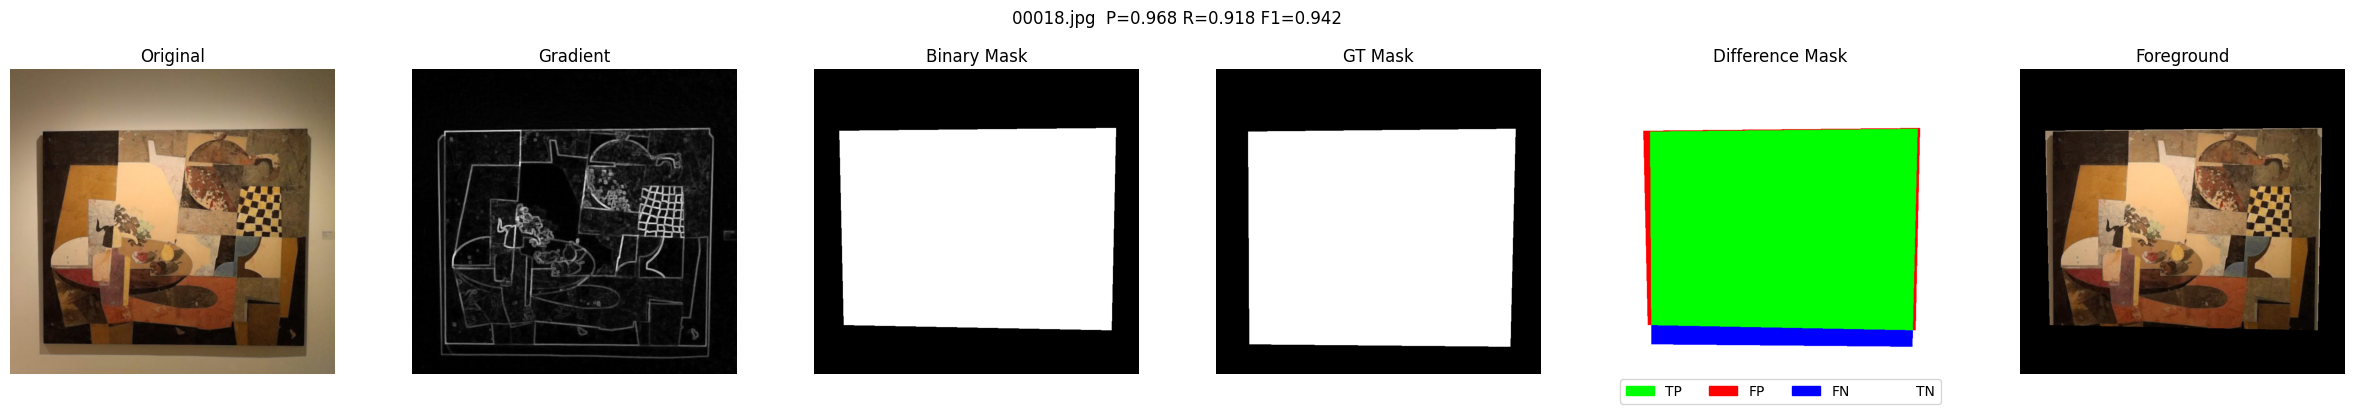

00019.jpg -> Precision: 0.9492, Recall: 1.0000, F1: 0.9740


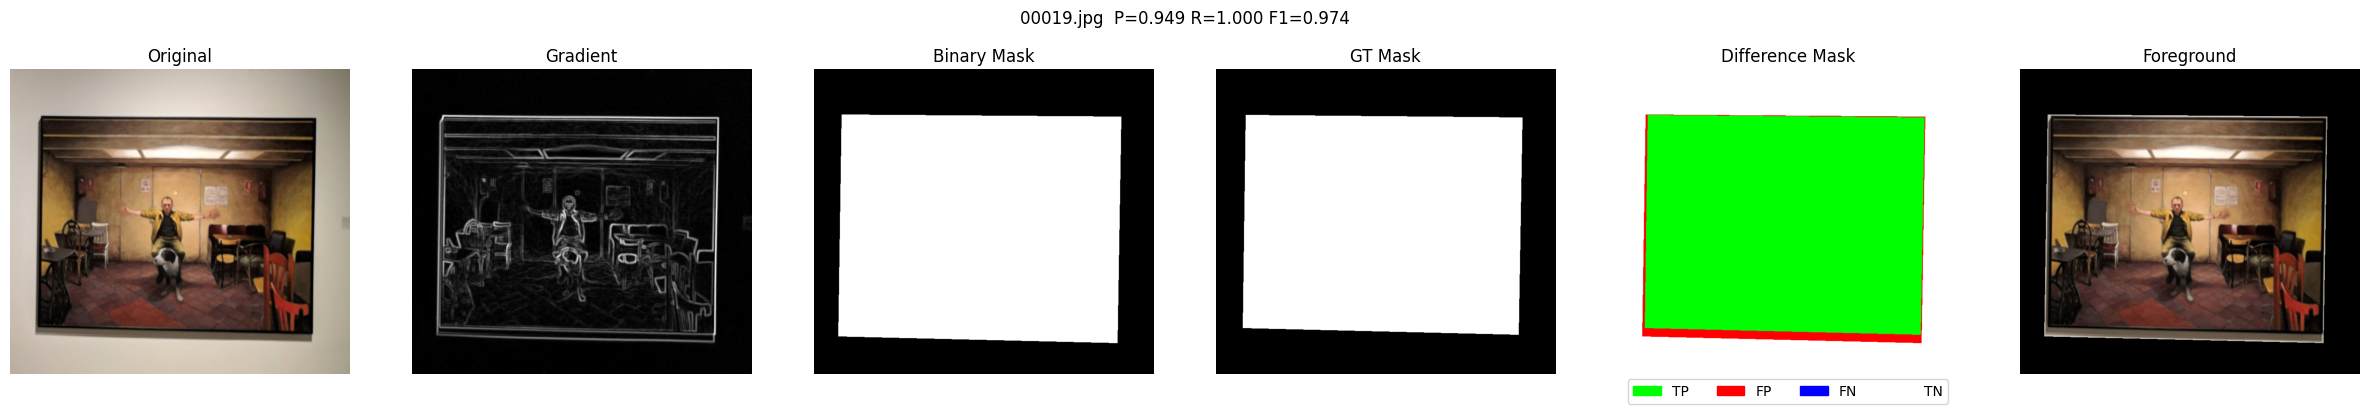

00020.jpg -> Precision: 0.9768, Recall: 0.9990, F1: 0.9878


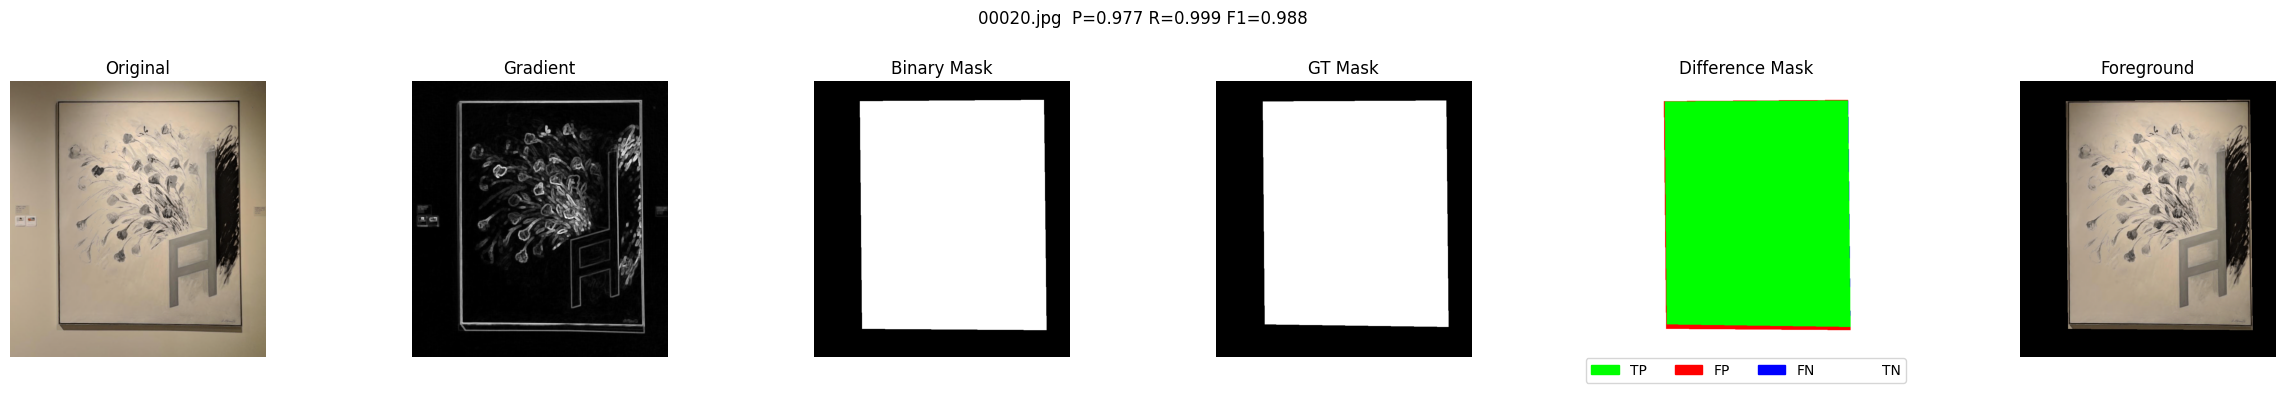

00021.jpg -> Precision: 0.9891, Recall: 0.9876, F1: 0.9883


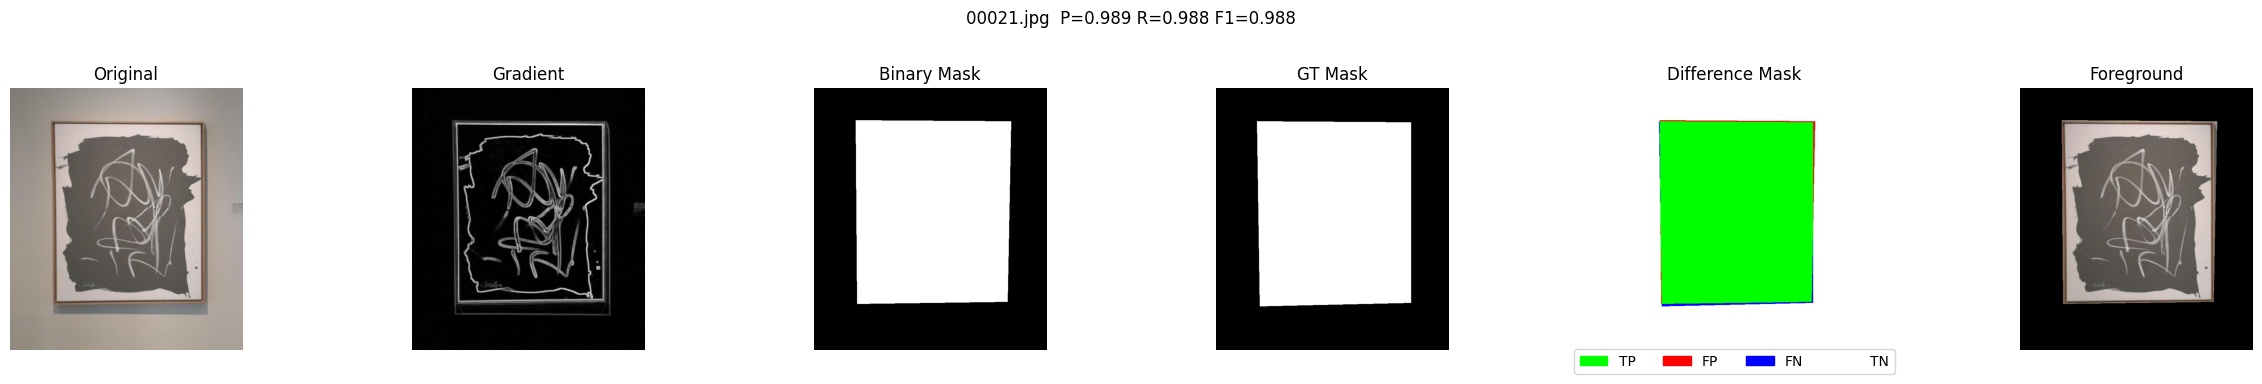

00022.jpg -> Precision: 0.9088, Recall: 0.9961, F1: 0.9504


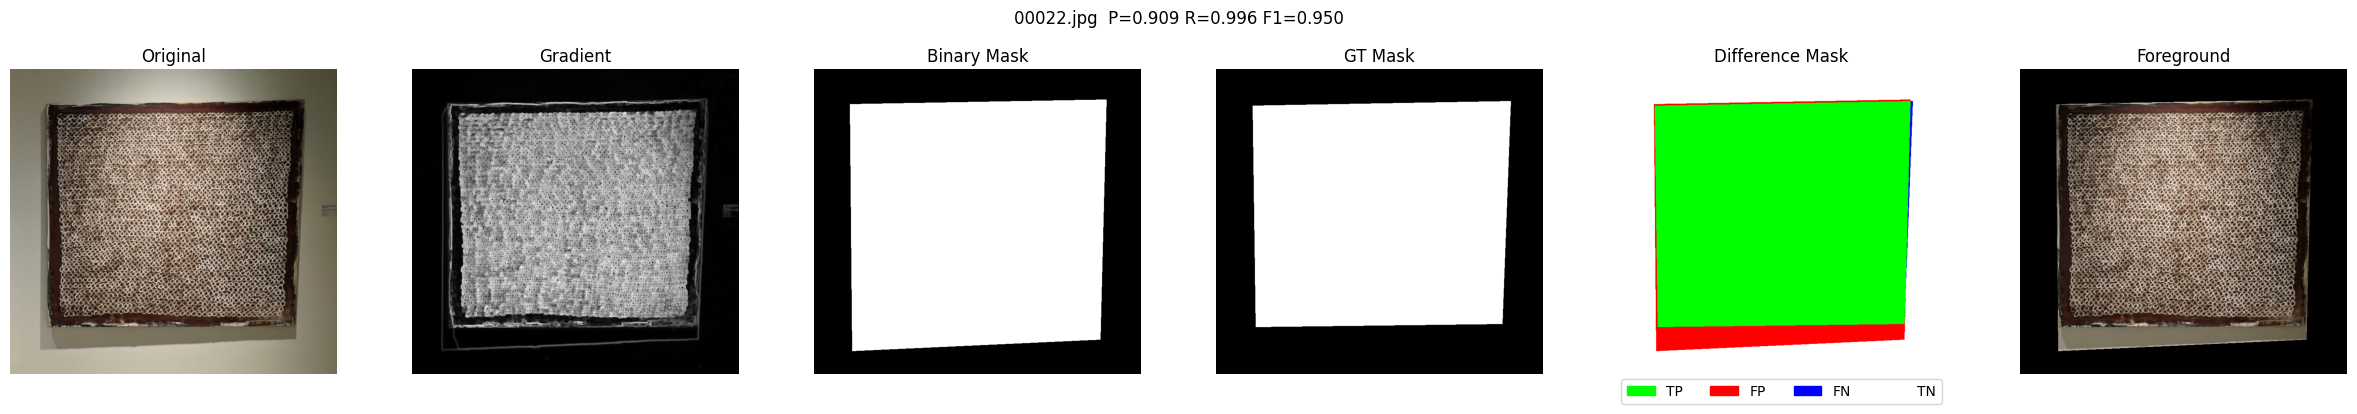

00023.jpg -> Precision: 0.9945, Recall: 0.9842, F1: 0.9893


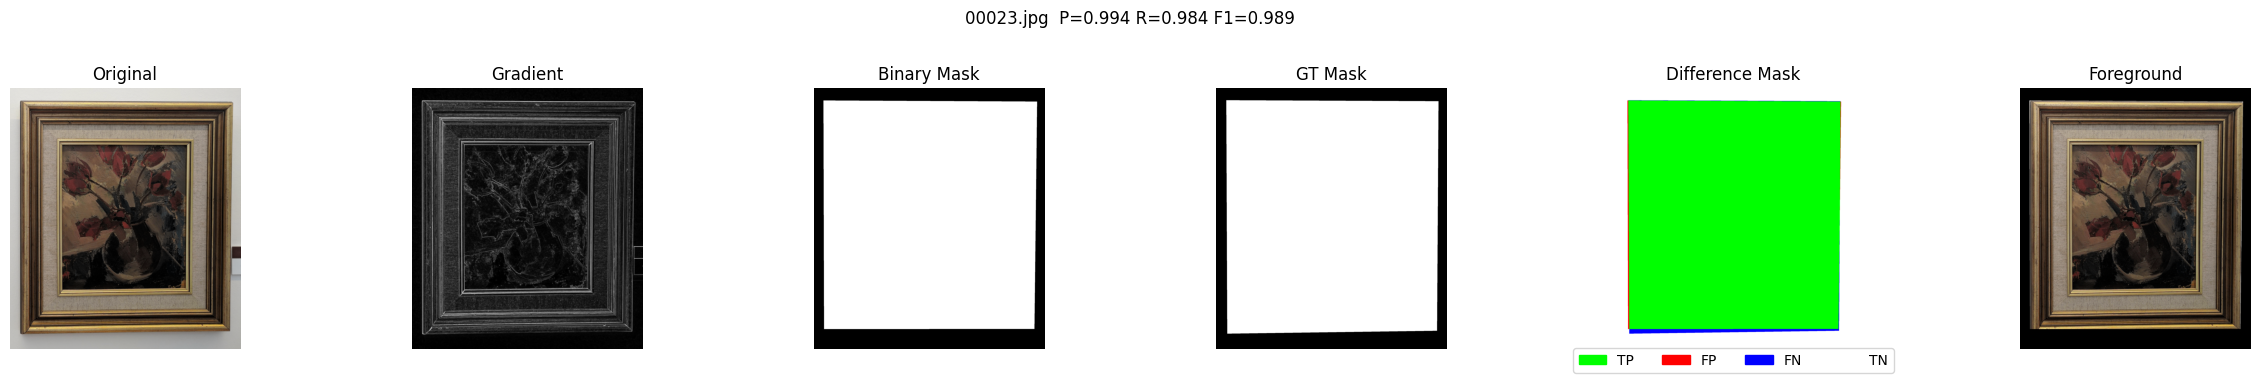

00024.jpg -> Precision: 0.9295, Recall: 1.0000, F1: 0.9635


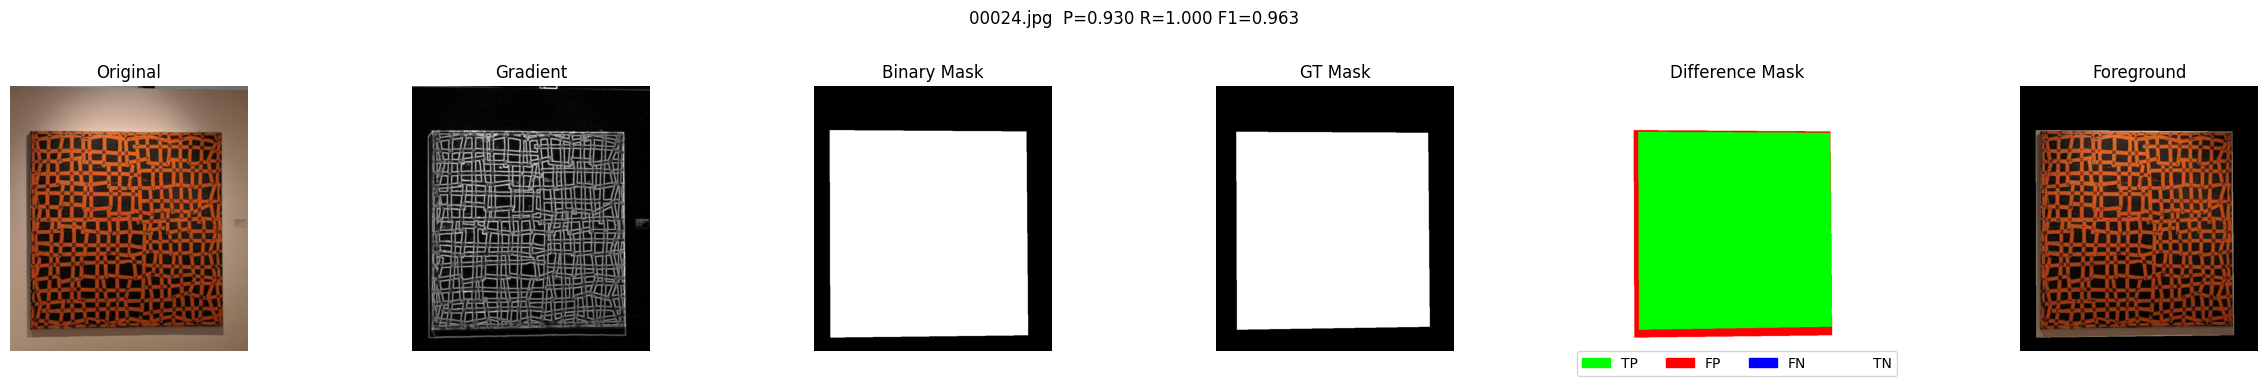

00025.jpg -> Precision: 0.9700, Recall: 0.9706, F1: 0.9703


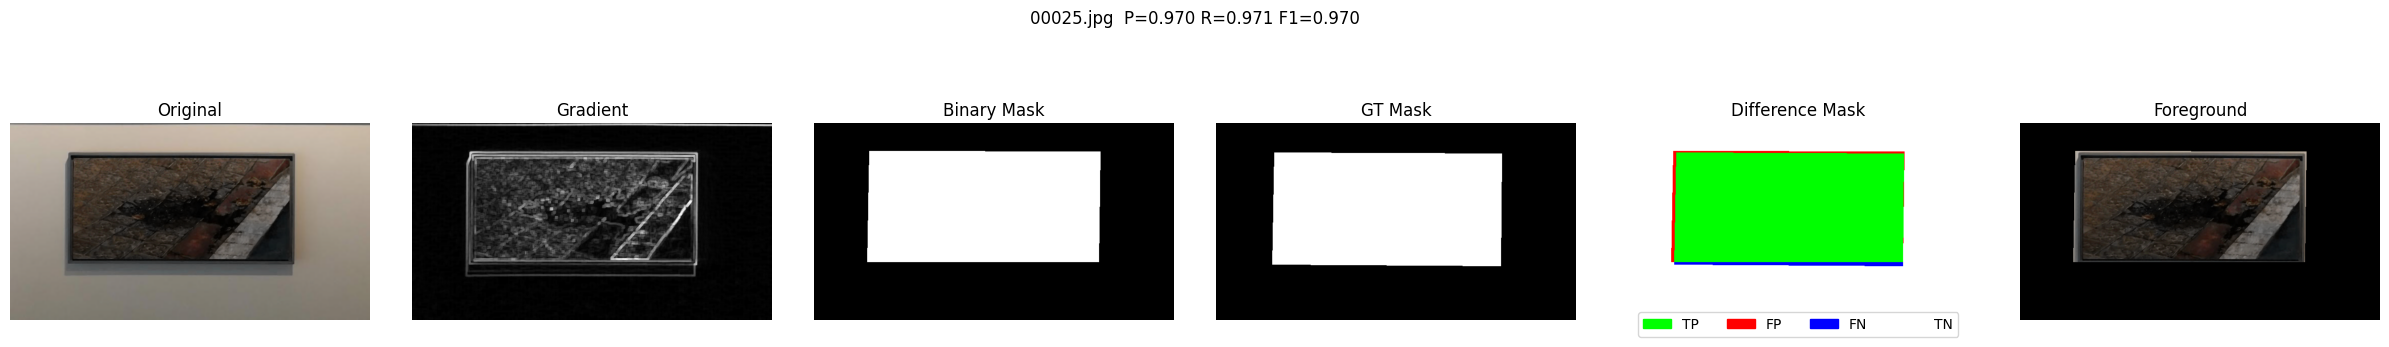

00026.jpg -> Precision: 0.9668, Recall: 0.9997, F1: 0.9830


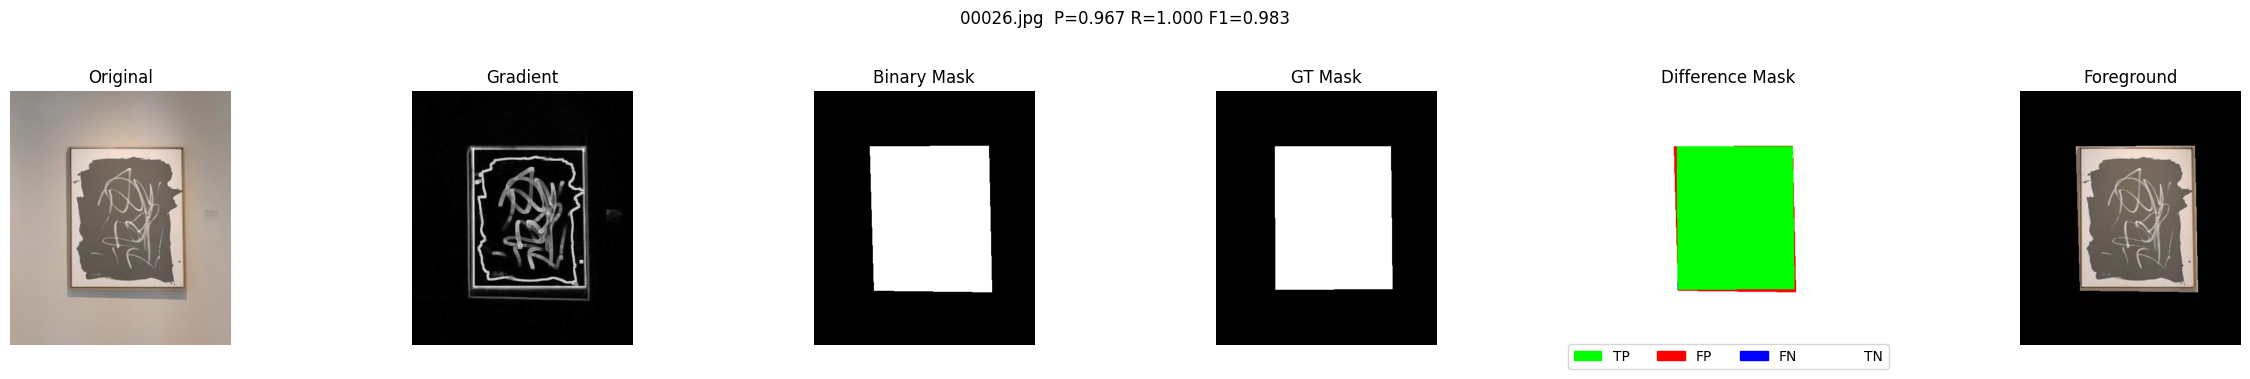

00027.jpg -> Precision: 0.9054, Recall: 1.0000, F1: 0.9504


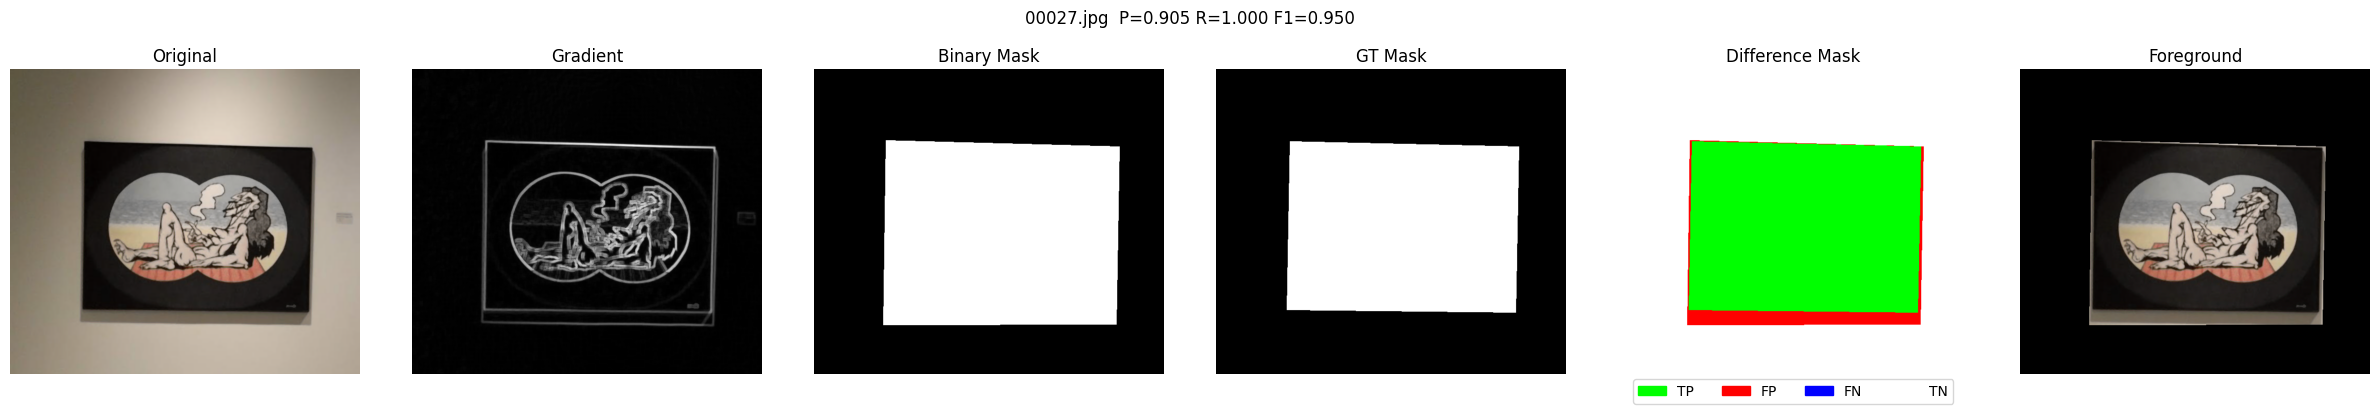

00028.jpg -> Precision: 0.9320, Recall: 0.9208, F1: 0.9264


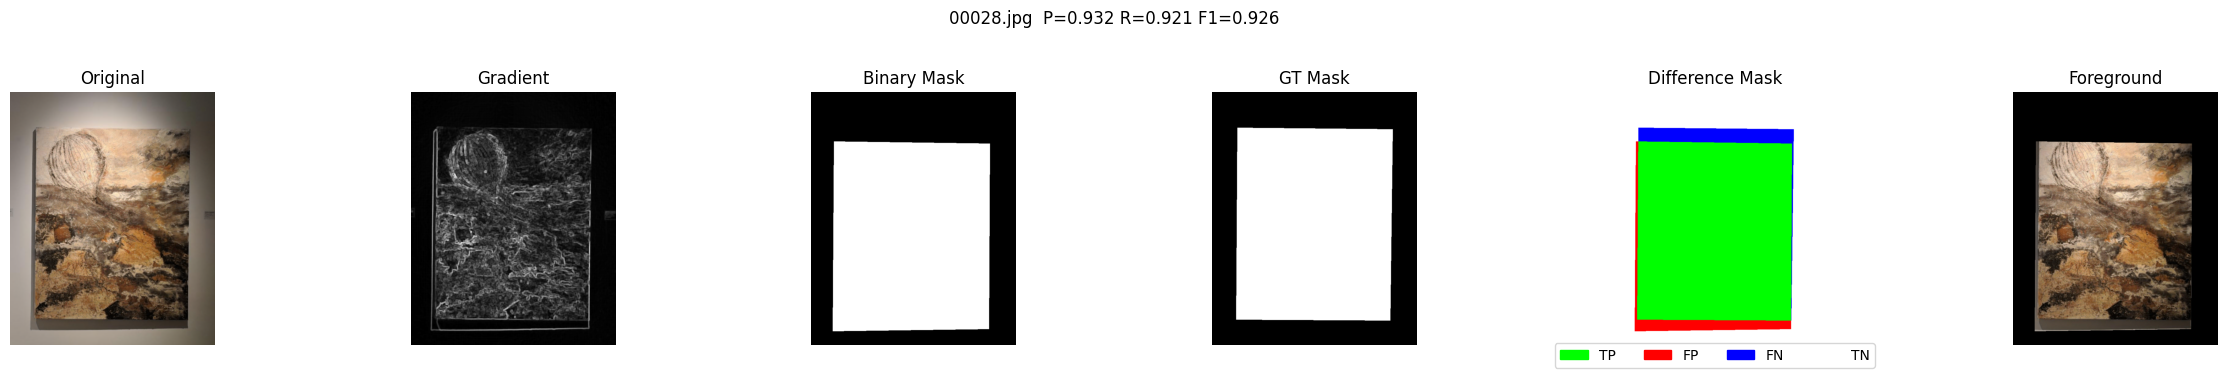

00029.jpg -> Precision: 0.9344, Recall: 0.9591, F1: 0.9466


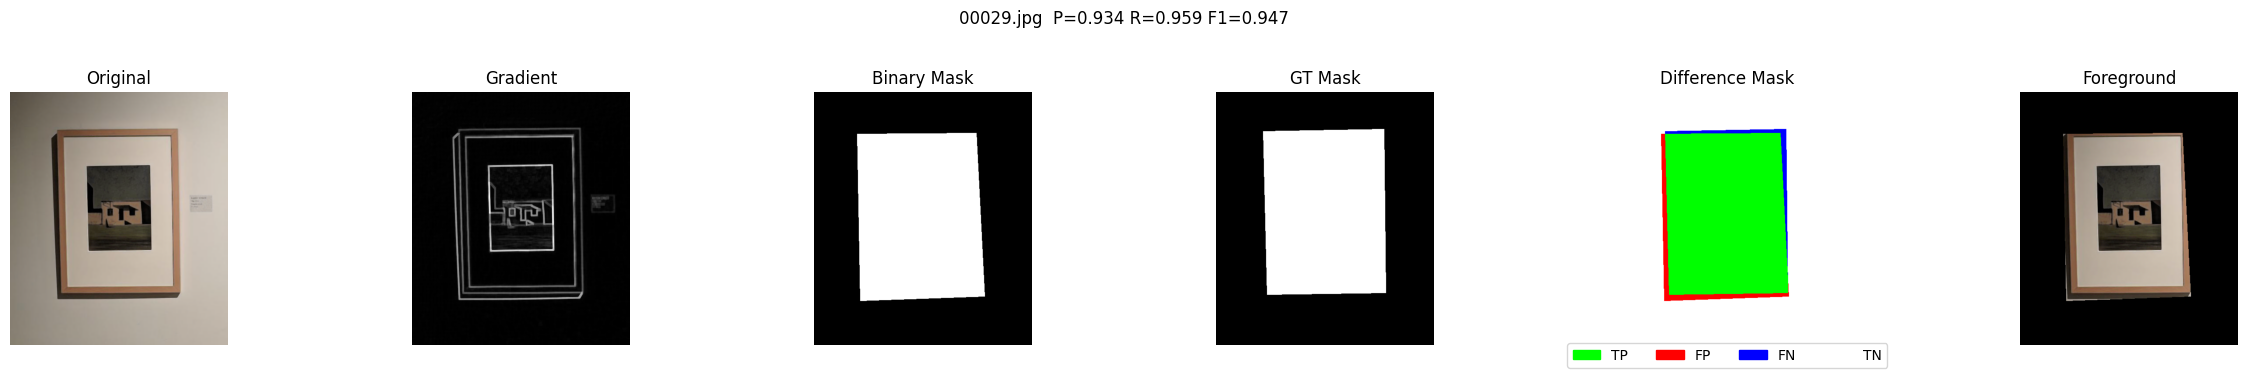


=== Global pixel-wise metrics ===
Total TP: 27294281, FP: 424917, FN: 517917, TN: 11284511
Global Precision: 0.9847
Global Recall:    0.9814
Global F1:        0.9830


In [44]:
# Iterar sobre imágenes, comparar con GT, calcular métricas y mostrar resultados
import matplotlib.patches as mpatches

# Toggle plotting of images. Set to False to speed-up and only print metrics.
SHOW_PLOTS = True

total_TP = total_FP = total_FN = total_TN = 0
precisions = []
recalls = []
f1s = []

for idx, image_file in enumerate(image_files):
    image_path = os.path.join(image_folder, image_file)
    # Now the function returns the gradient as grad_norm (2D uint8) instead of using a global debug list
    original_image, pred_mask, foreground, grad_norm = remove_background_morphological_gradient(image_path, filter='median', save_debug=False)
    
    # Asegurar máscara booleana predicha
    pred_bool = pred_mask.astype(bool)

    # Cargar GT (mismo nombre .png) y convertir a máscara booleana
    base = os.path.splitext(image_file)[0]
    gt_path = os.path.join(image_folder, base + '.png')
    if os.path.exists(gt_path):
        gt_raw = imageio.imread(gt_path)
        # Si GT tiene canales, convertir a gris
        if gt_raw.ndim == 3:
            gt_gray = rgb2gray(gt_raw)
        else:
            gt_gray = gt_raw
        gt_bool = gt_gray > 127
    else:
        gt_bool = np.zeros(pred_bool.shape, dtype=bool)

    # Calcular TP, FP, FN, TN (por píxel)
    TP = np.logical_and(pred_bool, gt_bool).sum()
    FP = np.logical_and(pred_bool, np.logical_not(gt_bool)).sum()
    FN = np.logical_and(np.logical_not(pred_bool), gt_bool).sum()
    TN = np.logical_and(np.logical_not(pred_bool), np.logical_not(gt_bool)).sum()

    total_TP += TP
    total_FP += FP
    total_FN += FN
    total_TN += TN

    # Precision, Recall, F1 para la imagen
    P = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    R = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    F1 = 2 * P * R / (P + R) if (P + R) > 0 else 0.0

    precisions.append(P)
    recalls.append(R)
    f1s.append(F1)

    print(f"{image_file} -> Precision: {P:.4f}, Recall: {R:.4f}, F1: {F1:.4f}")

    # If plotting is disabled, skip constructing and showing figures
    if not SHOW_PLOTS:
        continue

    # Create image of difference coloured (TP=green, FP=red, FN=blue, TN=white)
    h, w = pred_bool.shape
    diff_rgb = np.zeros((h, w, 3), dtype=np.uint8)
    diff_rgb[np.logical_and(pred_bool, gt_bool)] = [0, 255, 0]     # TP verde
    diff_rgb[np.logical_and(pred_bool, np.logical_not(gt_bool))] = [255, 0, 0]  # FP rojo
    diff_rgb[np.logical_and(np.logical_not(pred_bool), gt_bool)] = [0, 0, 255]  # FN azul
    diff_rgb[np.logical_and(np.logical_not(pred_bool), np.logical_not(gt_bool))] = [255, 255, 255]  # TN blanco

    # Prepare gradient RGB for display (stack single-channel to 3)
    grad_rgb = np.stack([grad_norm, grad_norm, grad_norm], axis=-1)

    # Mostrar: Original | Gradient | Binary Mask | GT Mask | Difference Mask | Foreground
    plt.figure(figsize=(24, 4))

    plt.subplot(1, 6, 1)
    plt.title('Original')
    plt.imshow(original_image)
    plt.axis('off')

    plt.subplot(1, 6, 2)
    plt.title('Gradient')
    plt.imshow(grad_rgb)
    plt.axis('off')

    plt.subplot(1, 6, 3)
    plt.title('Binary Mask')
    plt.imshow(pred_bool, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 4)
    plt.title('GT Mask')
    plt.imshow(gt_bool, cmap='gray')
    plt.axis('off')

    plt.subplot(1, 6, 5)
    plt.title('Difference Mask')
    plt.imshow(diff_rgb)
    plt.axis('off')

    # Leyenda para Difference Mask
    patches = [
        mpatches.Patch(color=(0, 1, 0), label='TP'),
        mpatches.Patch(color=(1, 0, 0), label='FP'),
        mpatches.Patch(color=(0, 0, 1), label='FN'),
        mpatches.Patch(color=(1, 1, 1), label='TN')
    ]
    plt.legend(handles=patches, loc='lower center', bbox_to_anchor=(0.5, -0.12), ncol=4)

    plt.subplot(1, 6, 6)
    plt.title('Foreground')
    plt.imshow(foreground)
    plt.axis('off')

    plt.suptitle(f"{image_file}  P={P:.3f} R={R:.3f} F1={F1:.3f}")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


# Métricas globales por píxel (acumuladas)
global_precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0.0
global_recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0.0
global_f1 = 2 * global_precision * global_recall / (global_precision + global_recall) if (global_precision + global_recall) > 0 else 0.0

print('\n=== Global pixel-wise metrics ===')
print(f'Total TP: {total_TP}, FP: {total_FP}, FN: {total_FN}, TN: {total_TN}')
print(f'Global Precision: {global_precision:.4f}')
print(f'Global Recall:    {global_recall:.4f}')
print(f'Global F1:        {global_f1:.4f}')